<a href="https://colab.research.google.com/github/sli032/BIO-PHY4100/blob/main/Viral_Capsid_Modeling_PyMembrane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viral Capsid Modeling with PyMembrane
This notebook demonstrates how to model a T=3 icosahedral viral capsid and compute its elastic energy using the [PyMembrane](https://github.com/fdmatoz/PyMembrane) package.

## Package Installation

In [1]:
# Install and setup (run only once)
!git clone https://github.com/fdmatoz/PyMembrane.git
%cd /content/PyMembrane/pymembrane/cppmodule/external
!rm -rf pybind11
!git clone https://github.com/pybind/pybind11.git pybind11
%cd /content/PyMembrane/
!python setup.py install

Cloning into 'PyMembrane'...
remote: Enumerating objects: 9112, done.
remote: Counting objects: 100% (6999/6999), done.
remote: Compressing objects: 100% (995/995), done.
remote: Total 9112 (delta 6686), reused 6075 (delta 6002), pack-reused 2113 (from 1)
Receiving objects: 100% (9112/9112), 52.83 MiB | 6.83 MiB/s, done.
Resolving deltas: 100% (7954/7954), done.
Updating files: 100% (1135/1135), done.
/content/PyMembrane/pymembrane/cppmodule/external
Cloning into 'pybind11'...
remote: Enumerating objects: 30750, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 30750 (delta 75), reused 58 (delta 43), pack-reused 30600 (from 4)
Receiving objects: 100% (30750/30750), 12.16 MiB | 16.91 MiB/s, done.
Resolving deltas: 100% (21843/21843), done.
/content/PyMembrane
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

       

## Load T=3 Icosahedral Capsid Mesh

In [4]:
%cd /content/
import pymembrane as pm
import numpy as np

/content


In [1]:
%%capture
!wget https://raw.githubusercontent.com/sli032/BIO-PHY4100/main/faces_T3.inp -O faces_T3.inp
!wget https://raw.githubusercontent.com/sli032/BIO-PHY4100/main/vertices_T3.inp -O vertices_T3.inp

In [2]:
!ls

faces_T1.inp  faces_T3.inp  PyMembrane	sample_data  vertices_T1.inp  vertices_T3.inp


In [5]:
box = pm.Box(40.0, 40.0, 40.0)
system = pm.System(box)

# Load the vertex and face files (ensure these are in the working directory)
vertex_file = 'vertices_T3.inp'
face_file = 'faces_T3.inp'
system.read_mesh_from_files(files={'vertices':vertex_file, 'faces':face_file})

dump = system.dumper
dump.vtk("initial mesh", False)

evolver = pm.Evolver(system)

Mesh
 Numvertices  32
 NumFaces  60
 NumEdges  90
 NumHEdges  180


## Define Elastic Properties and Compute Energy

In [6]:
evolver.add_force("Mesh>Harmonic", {"k": {"0": str(10.0)},
                                    "l0": {"0": str(1.0)}})

evolver.add_force("Mesh>Bending>Dihedral", {"kappa":{"0": str(10.0)}})
evolver.add_force("Mesh>Limit", {"lmin": {"0": str(0.7)},
                                 "lmax": {"0": str(1.3)}})

evolver.add_integrator("Mesh>MonteCarlo>vertex>move", {"dr":"0.008", "spherical_move": "false"})
evolver.add_integrator("Mesh>MonteCarlo>edge>swap", {"every step": str(100)})

In [7]:
compute = system.compute
edge_lengths = compute.edge_lengths()
print(edge_lengths)

[0.9341723589627162, 0.9999999999999998, 1.0000000000000002, 0.9999999999999998, 0.9341723589627149, 0.9341723589627153, 0.9999999999999991, 1.0, 1.0000000000000004, 1.0, 1.0000000000000007, 0.9999999999999997, 0.934172358962715, 0.9999999999999996, 0.9999999999999998, 0.9341723589627168, 0.9341723589627152, 0.9341723589627152, 0.9999999999999994, 0.9341723589627154, 1.0000000000000002, 0.9341723589627158, 0.9999999999999994, 0.9341723589627154, 0.9341723589627152, 0.9999999999999999, 0.9341723589627162, 0.9999999999999997, 1.0, 0.9999999999999999, 0.9999999999999994, 0.9341723589627149, 0.9341723589627154, 1.0000000000000002, 0.9341723589627163, 0.9999999999999998, 0.9999999999999999, 0.9999999999999998, 0.9999999999999996, 0.9341723589627151, 0.9341723589627157, 1.0000000000000009, 0.9341723589627163, 0.9999999999999997, 1.0, 0.9999999999999998, 1.0000000000000002, 0.9341723589627154, 1.0000000000000004, 0.9341723589627162, 1.0, 0.9999999999999994, 0.9341723589627143, 0.9341723589627

In [24]:
run_steps = 10000
## Compute the initial energy
mc_energy = 10*[None]
mc_energy[0] = compute.energy(evolver)['edges']/system.Numedges
print("[Initial] energy = {}".format(mc_energy[0]))
dump.vtk("sphere_t0")
for ti, temperature in enumerate([10^-3,10^-5,10^-7,0]):
    evolver.set_global_temperature(str(temperature))
    evolver.evolveMC(steps=run_steps)
    dump.vtk("sphere_t" + str(ti*run_steps))
    mc_energy[ti] =  compute.energy(evolver)['edges']/system.Numedges
    print("[{}] energy = {}".format(ti,  mc_energy[ti]))

dump.vtk('final_mesh')

[Initial] energy = 0.8289710323807816
[0] energy = 1.6409665057770886
[1] energy = 1.8587966124952235
[2] energy = 2.6270912411826055
[3] energy = 0.8289709424991925


## Visualization
To visualize the capsid structure, export the mesh and use a tool like [ParaView](https://www.paraview.org/).

In [9]:
!pip install pyvista
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 7.0 MB/s eta 0:00:00


In [25]:
!ls

faces_T1.inp	      PyMembrane	   sphere_t10000_edges.vtp  sphere_t30000_edges.vtp
faces_T3.inp	      sample_data	   sphere_t10000.vtp	    sphere_t30000.vtp
final_mesh_edges.vtp  sphere_t0_edges.vtp  sphere_t20000_edges.vtp  vertices_T1.inp
final_mesh.vtp	      sphere_t0.vtp	   sphere_t20000.vtp	    vertices_T3.inp


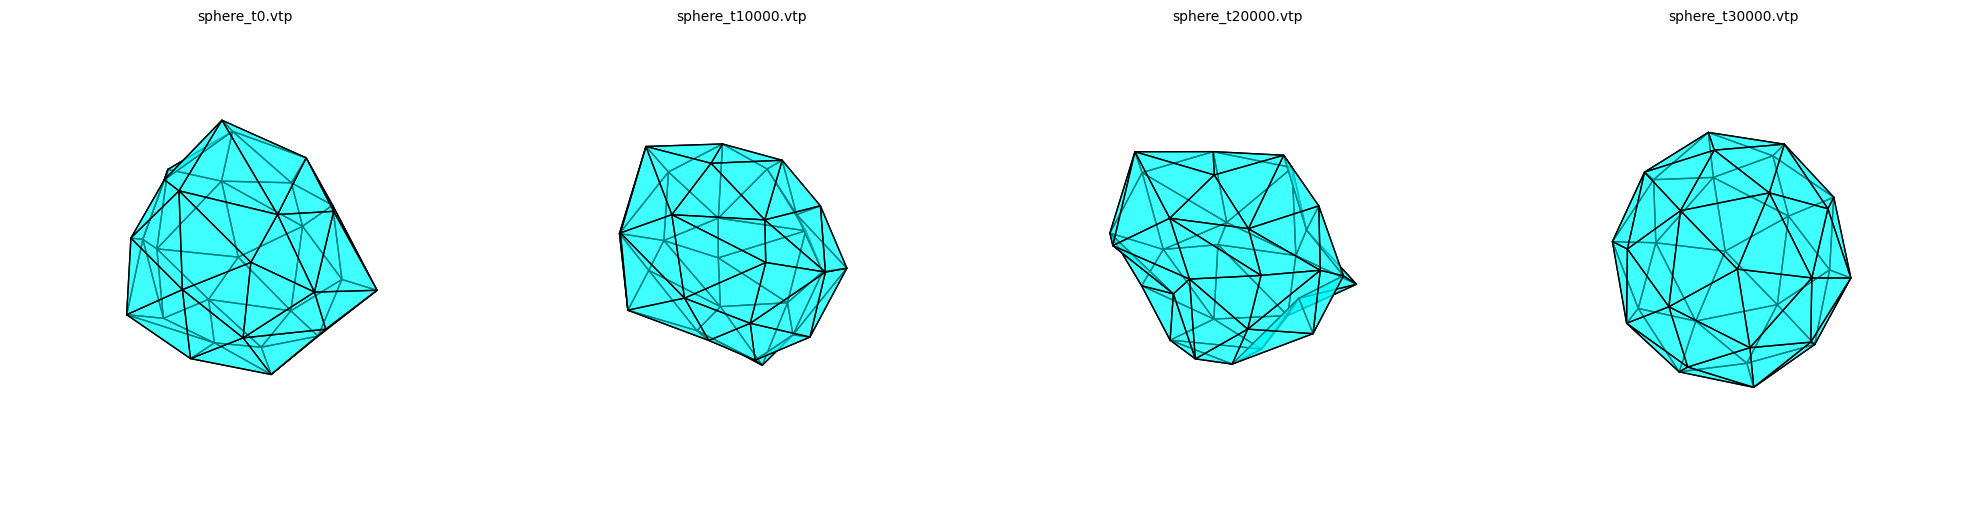

In [41]:
import pyvista as pv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import glob

file_list = glob.glob("*0.vtp")
file_list.sort()
n_files = len(file_list)
fig = plt.figure(figsize=(5 * n_files, 5))

for i, filename in enumerate(file_list):
    mesh = pv.read(filename)
    points = mesh.points
    faces = mesh.faces.reshape((-1, 4))[:, 1:]

    ax = fig.add_subplot(1, n_files, i + 1, projection='3d')

    poly3d = [points[face] for face in faces]
    collection = Poly3DCollection(poly3d, facecolor='cyan', edgecolor='k', alpha=0.5)
    ax.add_collection3d(collection)

    ax.auto_scale_xyz([-1.5, 1.5], [-1.5, 1.5], [-1.5, 1.5])
    ax.set_box_aspect([1, 1, 1])

    ax.set_title(filename, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# mesh = examples.download_bunny_coarse()
# cpos = [(0.2, 0.3, 0.9), (0, 0, 0), (0, 1, 0)]
# mesh.plot(cpos=cpos, show_edges=True, color=True, interactive=False)

## Comparison with Arbitrary Geometry
Repeat the same steps above using a different mesh file (with the same number of triangular subunits) and compare the resulting elastic energy.